# TPOT Autogluon

[PCoE][pcoe]の No.6 Turbofan Engine Degradation Simulation Dataset に対して [TPOT][tpot] を利用したAutoMLの実行テスト。

[pcoe]: https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/
[tpot]: http://epistasislab.github.io/tpot/


# Install TPOT

In [1]:
try:
    import tpot
except ModuleNotFoundError:
    # http://epistasislab.github.io/tpot/installing/
    # !pip install numpy scipy scikit-learn pandas joblib pytorch
    # !pip install deap update_checker tqdm stopit xgboost
    !pip install tpot


import tpot

     |████████████████████████████████| 92kB 6.2MB/s 
     |████████████████████████████████| 163kB 34.5MB/s 
     |████████████████████████████████| 166.7MB 84kB/s 
  Created wheel for stopit: filename=stopit-1.1.2-cp37-none-any.whl size=11954 sha256=88e6756e4df790ecf3473986a4f1732a116f132fd5c1affebd15edb856f06fc0
  Stored in directory: /root/.cache/pip/wheels/3c/85/2b/2580190404636bfc63e8de3dff629c03bb795021e1983a6cc7
Successfully built stopit
  Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


# Preset

In [2]:
# default packages
import logging
import pathlib
import zipfile
from typing import Any, Dict, List, Sequence, Tuple

In [3]:
# third party packages
import IPython.display as display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import sklearn.model_selection as skmselection
import tqdm.autonotebook as tqdm
from sklearn.pipeline import Pipeline

In [4]:
# mode
MODE_DEBUG = False

In [5]:
# logger
_logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.DEBUG if MODE_DEBUG else logging.INFO)

In [6]:
# seaborn
sns.set()

# Global parameters

In [7]:
PATH_ARCHIVE = pathlib.Path("turbofun.zip")
PATH_EXTRACT = pathlib.Path("turbofun")

In [8]:
# 利用する変数を定義
COLUMNS_ALL = [
    *[f"op{i:02}" for i in range(3)],
    *[f"sensor{i:02}" for i in range(26)],
]
COLUMNS_INVALID = [
    "op02",
    "sensor01",
    "sensor04",
    "sensor09",
    "sensor15",
    "sensor17",
    "sensor18",
    "sensor21",
    "sensor22",
    "sensor23",
    "sensor24",
    "sensor25",
]
COLUMNS_VALID = sorted(list(set(COLUMNS_ALL) - set(COLUMNS_INVALID)))

COLUMNS_TARGET = ["rul"]

# Load dataset

In [9]:
def download(filename: pathlib.Path) -> None:
    """zipファイルをダウンロード."""
    if filename.exists():
        return

    url = "https://ti.arc.nasa.gov/c/6/"
    res = requests.get(url, stream=True)
    if res.status_code != 200:
        _logger.error(res.status_code)
        return

    with open(filename, "wb") as f:
        for chunk in tqdm.tqdm(res):
            f.write(chunk)


download(PATH_ARCHIVE)

In [10]:
def extractall(src: pathlib.Path, dst: pathlib.Path) -> None:
    """zipファイルを解凍."""
    if not src.exists():
        _logger.error(f"{src} does not exist.")
        return
    if dst.exists():
        _logger.error(f"{dst} exists.")
        return

    with zipfile.ZipFile(src) as zf:
        zf.extractall(dst)


extractall(PATH_ARCHIVE, PATH_EXTRACT)

# Convert data shape

In [11]:
def get_unit_series(df: pd.DataFrame, unit: int) -> Dict[str, Any]:
    """unit単位のnumpy.arrayへ変換する."""
    df_unit = df[df["unit"] == unit].copy()
    df_unit.sort_values(by=["time"], ignore_index=True, inplace=True)
    names_op = [f"op{i:02}" for i in range(3)]
    names_sensor = [f"sensor{i:02}" for i in range(26)]
    data = {
        "unit": unit,
        **{name: df_unit[name].to_numpy().ravel() for name in names_op},
        **{name: df_unit[name].to_numpy().ravel() for name in names_sensor},
    }

    return data


def load_data(filename: pathlib.Path) -> pd.DataFrame:
    """データを読み取り、1セルに1unit分のデータをnumpy.arrayで保持するDataFrameとする."""
    df = pd.read_csv(
        filename,
        header=None,
        sep=" ",
        names=[
            "unit",
            "time",
            *[f"op{i:02d}" for i in range(3)],
            *[f"sensor{i:02d}" for i in range(26)],
        ],
    )

    return df


DF_FD001_TRAIN = load_data(PATH_EXTRACT.joinpath("train_FD001.txt"))
DF_FD001_TEST = load_data(PATH_EXTRACT.joinpath("test_FD001.txt"))

In [12]:
display.display(DF_FD001_TRAIN)

,unit,time,op00,op01,op02,sensor00,sensor01,sensor02,sensor03,sensor04,sensor05,sensor06,sensor07,sensor08,sensor09,sensor10,sensor11,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,sensor22,sensor23,sensor24,sensor25
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN,NaN,NaN,NaN
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN,NaN,NaN,NaN
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN,NaN,NaN,NaN
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN,NaN,NaN,NaN
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,21.61,551.43,2388.19,9065.52,1.3,48.07,519.49,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735,NaN,NaN,NaN,NaN,NaN
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,21.61,550.86,2388.23,9065.11,1.3,48.04,519.68,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594,NaN,NaN,NaN,NaN,NaN
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,21.61,550.94,2388.24,9065.90,1.3,48.09,520.01,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333,NaN,NaN,NaN,NaN,NaN
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,21.61,550.68,2388.25,9073.72,1.3,48.39,519.67,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640,NaN,NaN,NaN,NaN,NaN


In [13]:
display.display(DF_FD001_TEST)

,unit,time,op00,op01,op02,sensor00,sensor01,sensor02,sensor03,sensor04,sensor05,sensor06,sensor07,sensor08,sensor09,sensor10,sensor11,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,sensor22,sensor23,sensor24,sensor25
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,21.61,553.90,2388.04,9050.17,1.3,47.20,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,NaN,NaN,NaN,NaN,NaN
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,21.61,554.85,2388.01,9054.42,1.3,47.50,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,NaN,NaN,NaN,NaN,NaN
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,21.61,554.11,2388.05,9056.96,1.3,47.50,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,NaN,NaN,NaN,NaN,NaN
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,21.61,554.07,2388.03,9045.29,1.3,47.28,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,NaN,NaN,NaN,NaN,NaN
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,21.61,554.16,2388.01,9044.55,1.3,47.31,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.0049,0.0000,100.0,518.67,643.24,1599.45,1415.79,14.62,21.61,553.41,2388.02,9142.37,1.3,47.69,520.69,2388.00,8213.28,8.4715,0.03,394,2388,100.0,38.65,23.1974,NaN,NaN,NaN,NaN,NaN
13092,100,195,-0.0011,-0.0001,100.0,518.67,643.22,1595.69,1422.05,14.62,21.61,553.22,2388.05,9140.68,1.3,47.60,521.05,2388.09,8210.85,8.4512,0.03,395,2388,100.0,38.57,23.2771,NaN,NaN,NaN,NaN,NaN
13093,100,196,-0.0006,-0.0003,100.0,518.67,643.44,1593.15,1406.82,14.62,21.61,553.04,2388.11,9146.81,1.3,47.57,521.18,2388.04,8217.24,8.4569,0.03,395,2388,100.0,38.62,23.2051,NaN,NaN,NaN,NaN,NaN
13094,100,197,-0.0038,0.0001,100.0,518.67,643.26,1594.99,1419.36,14.62,21.61,553.37,2388.07,9148.85,1.3,47.61,521.33,2388.08,8220.48,8.4711,0.03,395,2388,100.0,38.66,23.2699,NaN,NaN,NaN,NaN,NaN


In [14]:
def load_rul(filepath: pathlib.Path) -> pd.DataFrame:
    """テスト用のRULを読み込む."""
    df = pd.read_csv(
        filepath,
        header=None,
        sep=" ",
        names=["rul", "none"],
    )
    df.drop(["none"], axis=1, inplace=True)
    df["unit"] = range(len(df))
    df.set_index(["unit"], inplace=True)

    return df


DF_FD001_TEST_RUL = load_rul(PATH_EXTRACT.joinpath("RUL_FD001.txt"))
display.display(DF_FD001_TEST_RUL)

,rul
unit,
0,112
1,98
2,69
3,82
4,91
...,...
95,137
96,82
97,59


In [15]:
def create_train_rul(df: pd.DataFrame) -> pd.Series:
    """学習データに対するRULを算出する."""
    df_rul = df.copy()
    df_max_time = df.groupby(["unit"])["time"].max()
    df_rul["rul"] = df_rul.apply(
        lambda x: df_max_time.at[x["unit"]] - x["time"],
        axis=1,
    )

    return df_rul



DF_FD001_TRAIN = create_train_rul(DF_FD001_TRAIN)
display.display(DF_FD001_TRAIN)

,unit,time,op00,op01,op02,sensor00,sensor01,sensor02,sensor03,sensor04,sensor05,sensor06,sensor07,sensor08,sensor09,sensor10,sensor11,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,sensor22,sensor23,sensor24,sensor25,rul
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN,NaN,NaN,NaN,191.0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN,NaN,NaN,NaN,190.0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN,NaN,NaN,NaN,189.0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN,NaN,NaN,NaN,188.0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN,NaN,NaN,NaN,187.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,21.61,551.43,2388.19,9065.52,1.3,48.07,519.49,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735,NaN,NaN,NaN,NaN,NaN,4.0
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,21.61,550.86,2388.23,9065.11,1.3,48.04,519.68,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594,NaN,NaN,NaN,NaN,NaN,3.0
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,21.61,550.94,2388.24,9065.90,1.3,48.09,520.01,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333,NaN,NaN,NaN,NaN,NaN,2.0
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,21.61,550.68,2388.25,9073.72,1.3,48.39,519.67,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640,NaN,NaN,NaN,NaN,NaN,1.0


# Data split

In [16]:
def train_test_split(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """学習用データと検証用データを分割する."""
    units = df["unit"].unique()
    units_train, units_test = skmselection.train_test_split(
        units,
        test_size=0.2,
        random_state=42,
    )

    df_train = df[df["unit"].isin(units_train)]
    df_test = df[df["unit"].isin(units_test)]

    return df_train, df_test


DF_TRAIN, DF_VALID = train_test_split(DF_FD001_TRAIN)

In [17]:
DF_TRAIN.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16561 entries, 192 to 20630
Data columns (total 32 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   unit      16561 non-null  int64  
 1   time      16561 non-null  int64  
 2   op00      16561 non-null  float64
 3   op01      16561 non-null  float64
 4   op02      16561 non-null  float64
 5   sensor00  16561 non-null  float64
 6   sensor01  16561 non-null  float64
 7   sensor02  16561 non-null  float64
 8   sensor03  16561 non-null  float64
 9   sensor04  16561 non-null  float64
 10  sensor05  16561 non-null  float64
 11  sensor06  16561 non-null  float64
 12  sensor07  16561 non-null  float64
 13  sensor08  16561 non-null  float64
 14  sensor09  16561 non-null  float64
 15  sensor10  16561 non-null  float64
 16  sensor11  16561 non-null  float64
 17  sensor12  16561 non-null  float64
 18  sensor13  16561 non-null  float64
 19  sensor14  16561 non-null  float64
 20  sensor15  16561 non-null  

In [18]:
DF_VALID.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4070 entries, 0 to 18514
Data columns (total 32 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   unit      4070 non-null   int64  
 1   time      4070 non-null   int64  
 2   op00      4070 non-null   float64
 3   op01      4070 non-null   float64
 4   op02      4070 non-null   float64
 5   sensor00  4070 non-null   float64
 6   sensor01  4070 non-null   float64
 7   sensor02  4070 non-null   float64
 8   sensor03  4070 non-null   float64
 9   sensor04  4070 non-null   float64
 10  sensor05  4070 non-null   float64
 11  sensor06  4070 non-null   float64
 12  sensor07  4070 non-null   float64
 13  sensor08  4070 non-null   float64
 14  sensor09  4070 non-null   float64
 15  sensor10  4070 non-null   float64
 16  sensor11  4070 non-null   float64
 17  sensor12  4070 non-null   float64
 18  sensor13  4070 non-null   float64
 19  sensor14  4070 non-null   float64
 20  sensor15  4070 non-null   flo

# TPOT

In [19]:
def fit(df_feature: pd.DataFrame, df_target: pd.DataFrame) -> tpot.TPOTRegressor:
    """モデルの探索."""
    generations = 3 if MODE_DEBUG else 100
    population_size = 5 if MODE_DEBUG else 100
    max_time_mins = None if MODE_DEBUG else 60

    regressor = tpot.TPOTRegressor(
        generations=generations,
        population_size=population_size,
        max_time_mins=max_time_mins,
        scoring="neg_mean_squared_error",
        cv=5,
        n_jobs=-1,
        random_state=42,
        verbosity=2,
    )
    regressor.fit(
        df_feature.to_numpy(),
        df_target.to_numpy().ravel(),
    )
    regressor.export("tpot_pcoe06_pipeline.py")


fit(DF_TRAIN[COLUMNS_VALID], DF_TRAIN[COLUMNS_TARGET])


Generation 1 - Current best internal CV score: -1983.1343594684477

Generation 2 - Current best internal CV score: -1982.0877715659894

60.45 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: ExtraTreesRegressor(input_matrix, bootstrap=False, max_features=0.35000000000000003, min_samples_leaf=4, min_samples_split=10, n_estimators=100)


In [20]:
!cat tpot_pcoe06_pipeline.py

import numpy as np
import pandas as pd
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import train_test_split

# NOTE: Make sure that the outcome column is labeled 'target' in the data file
tpot_data = pd.read_csv('PATH/TO/DATA/FILE', sep='COLUMN_SEPARATOR', dtype=np.float64)
features = tpot_data.drop('target', axis=1)
training_features, testing_features, training_target, testing_target = \
            train_test_split(features, tpot_data['target'], random_state=42)

# Average CV score on the training set was: -1982.0877715659894
exported_pipeline = ExtraTreesRegressor(bootstrap=False, max_features=0.35000000000000003, min_samples_leaf=4, min_samples_split=10, n_estimators=100)
# Fix random state in exported estimator
if hasattr(exported_pipeline, 'random_state'):
    setattr(exported_pipeline, 'random_state', 42)

exported_pipeline.fit(training_features, training_target)
results = exported_pipeline.predict(testing_features)


In [32]:
def export_pipeline(df_features: pd.DataFrame, df_target: pd.DataFrame) -> Pipeline:
    import sklearn.pipeline as skpipeline
    import tpot.export_utils as export_utils
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.linear_model import ElasticNetCV, LassoLarsCV
    from tpot.builtins import StackingEstimator

    exported_pipeline = skpipeline.make_pipeline(
        StackingEstimator(estimator=LassoLarsCV(normalize=False)),
        StackingEstimator(estimator=ElasticNetCV(l1_ratio=0.75, tol=0.01)),
        RandomForestRegressor(bootstrap=True, max_features=0.4, min_samples_leaf=16, min_samples_split=14, n_estimators=100),
    )
    export_utils.set_param_recursive(exported_pipeline.steps, "random_state", 42)
    exported_pipeline.fit(df_features.to_numpy(), df_target.to_numpy().ravel())

    return exported_pipeline


EXPORTED_PIPELINE = export_pipeline(DF_TRAIN[COLUMNS_VALID], DF_TRAIN[COLUMNS_TARGET])

## Results

In [35]:
def predict(
    pipeline: Pipeline,
    df_info: pd.DataFrame,
    df_feature: pd.DataFrame,
    df_target: pd.DataFrame,
    units: List[int],
) -> None:
    """予測結果を可視化する."""
    results = pipeline.predict(df_feature.to_numpy())
    df_results = df_info.copy()
    df_results["rul"] = df_target.to_numpy().ravel()
    df_results["pred"] = results

    for unit in units:
        df_target = df_results[df_results["unit"] == unit]
        fig, axes = plt.subplots(1, 1, figsize=(9, 4), tight_layout=True)
        ax = axes
        ax.plot(df_target["time"], df_target["rul"], label="rul")
        ax.plot(df_target["time"], df_target["pred"], label="pred")
        ax.set_title(f"unit{unit:02}")
        plt.show()
        plt.close()
        fig.clf()

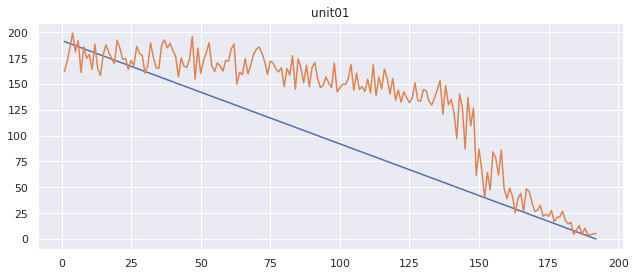

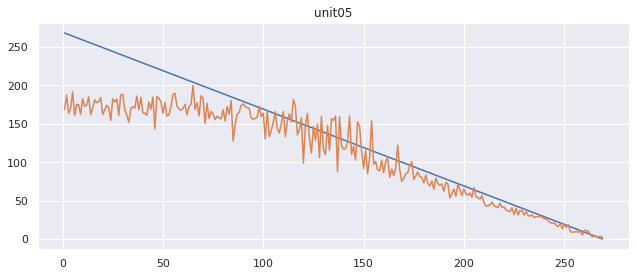

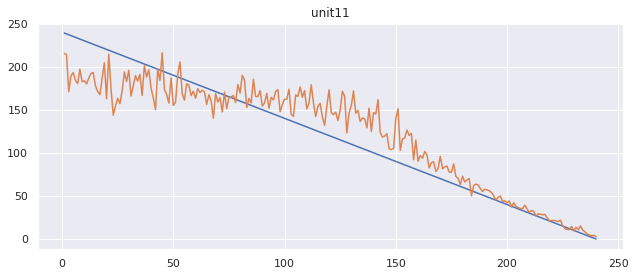

In [37]:
predict(
    EXPORTED_PIPELINE,
    DF_VALID[["unit", "time"]],
    DF_VALID[COLUMNS_VALID],
    DF_VALID[COLUMNS_TARGET],
    DF_VALID["unit"].unique()[:3],
)